# Anomaly Detection using Autoencoder



We are going perform unsupervised anomaly detection on the voltage Time series. We are going to train our model in our normal dataset and then we will test it on the given abnormal dataset to test its ability to spot anomalies. The autoencoder will try to reproduce the given input, but since it is trained on the normal dataset, the reconstruction error of the abnormal samples should be larger that the error on the normal dataset.So by setting a threshold on this reconstruction error we can detect outliers on anomalies.

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import seaborn as sns
from pylab import rcParams
from sklearn.utils import shuffle
from pdb import set_trace
import matplotlib.pylab as plt
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

In [2]:
'''
 ' Huber loss.
 ' https://jaromiru.com/2017/05/27/on-using-huber-loss-in-deep-q-learning/
 ' https://en.wikipedia.org/wiki/Huber_loss
'''
def huber_loss(y_true, y_pred, clip_delta=1.0):
  error = y_true - y_pred
  cond  = tf.keras.backend.abs(error) < clip_delta

  squared_loss = 0.5 * tf.keras.backend.square(error)
  linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

  return tf.where(cond, squared_loss, linear_loss)

'''
 ' Same as above but returns the mean loss.
'''
def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
  return tf.keras.backend.mean(huber_loss(y_true, y_pred, clip_delta))

The loss function we used in training our models is Huber loss, since it is more less sensitive to outliers than squared error loss.

In [3]:
sys.path.append('/home/aggelos-i3/ForecastingLib/')
from tsutils import SequenceSpliter

In [4]:
rcParams['figure.figsize'] = 20, 12
sns.set()

## Preprocessing

In this step we chose the features our model is going to use. To reduce noise we use a moving average of the ten most recent samples, smoothing our sequences making it easier for our models to learn the underlying features. 

In [5]:
LOOKBACK = 100
LOOK_AHEAD = 1
ROLL_WINDOW = 10
features=['voltage [V]', 
          'acceleration (actual) [m/(s*s)]', 
          'tractive effort (actual) [kN]',
           'track-earth voltage [V]',
          'speed (actual) [km/h]',
          'current [A]',
          'energy balance [kWh]',
          'way (actual) [km]',
          'line and running resistance [kN]',
          'train configuration [1]',
          'energy input [kWh]',
          'train configuration [1]',
          'usable braking energy [kWh]',
          'used braking energy [kWh]'
         ]
nb_features = len(features)

In [6]:
df_new = pd.DataFrame()
s = 0.
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33NO").glob(
    '**/*.xls')
for path in pathlist:
    path_in_str = str(path)
    df = pd.read_csv(path_in_str, delimiter='\t', usecols=features)
    if df_new.empty:
        df_new = df[:1000]
    else:
        df_new += df[:1000]
    s += 1.

df_new /= s
df_new = df_new.rolling(window=ROLL_WINDOW).mean().dropna()

Therefore we have a new smoothed dataset of the features we chose. We standarize our dataset featurewise, so that every column has a mean of 1 and a variation of 0. 

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = StandardScaler()
y_idx = df_new.columns.get_loc('voltage [V]') #which series we try to replicate
scaler = scaler.fit(df_new)
df_scaled = scaler.transform(df_new)
spliter = SequenceSpliter(lookback=LOOKBACK, look_ahead=LOOK_AHEAD)

We split our timeseries into sequences of 100 samples with one step difference. And we select the feature we want our autoencoder to reproduce, in our case the __Voltage__.

In [8]:
X, y = spliter.fit_transform(df_scaled)
y = y[:, :, y_idx] 

The choice of the preprocessing hyperparameters, like the window for the smoothing and the splitting window, is empirical and based on trial and error. 

We are going to implement and test 3 neural network autoencoders. One using recurrent cells (GRUs or LSTMs) the second one is a fully convolutional autoencoder and the third one is a convolutional autoencoder with maxpooling layers.

### Simple AutoEncoder

In [9]:
inputs = Input(shape=X.shape[1:])
encoder = Flatten()(inputs)
encoder = Dropout(0.5)(encoder)
encoder = Dense(256, activation='relu')(encoder)
encoder = Dropout(0.5)(encoder)

encoder = Dense(128, activation='relu')(encoder)
encoder = Dropout(0.5)(encoder)

encoder = Dense(32, activation='relu')(encoder)

decoder = Dense(128, activation='relu')(encoder)
encoder = Dropout(0.5)(encoder)

decoder = Dense(256, activation='relu')(decoder)
decoder = Dropout(0.5)(decoder)
out = Dense(LOOKBACK)(decoder)
simple_ae = Model(inputs, out)
simple_ae.compile(loss=huber_loss_mean, optimizer='adam')
simple_ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 13)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1300)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1300)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               333056    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

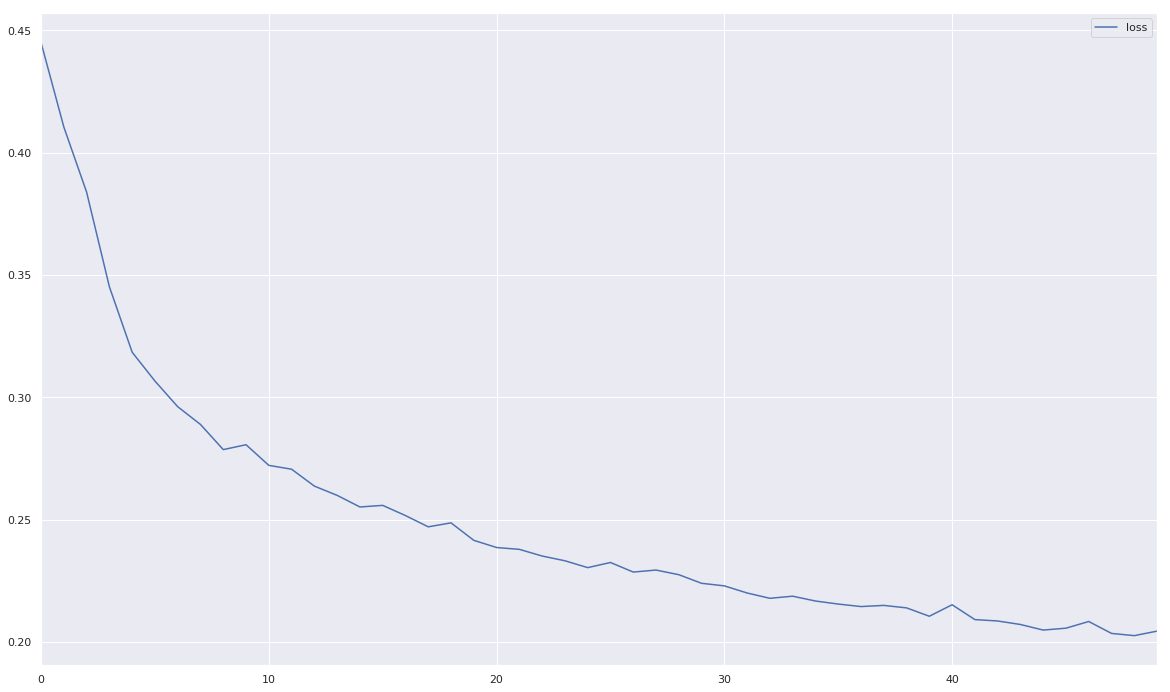

In [10]:
history1 = simple_ae.fit(X, X[:,:,y_idx], epochs=50, verbose=0)
history1 = pd.DataFrame(history1.history)
history1.plot()

### Reccurent Autoencoder

Here we define and train our reccurent autoencoder.

In [11]:
inputs = Input(shape=X.shape[1:])
encoder = GRU(LOOKBACK, return_sequences=True)(inputs)
encoder = Dropout(0.5)(encoder)
encoder = GRU(32, return_sequences=True)(encoder)
encoder = Dropout(0.5)(encoder)
encoder = GRU(13, return_sequences=True)(encoder)
decoder = GRU(32, return_sequences=True)(encoder)
decoder = Dropout(0.5)(decoder)
out = GRU(LOOKBACK, return_sequences=False)(decoder)
LSTM_AE = Model(inputs, out)
LSTM_AE.compile(loss=huber_loss_mean, optimizer='adam')
LSTM_AE.summary()
tf.keras.utils.plot_model(LSTM_AE, 'r_ae.png', show_shapes=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 13)           0         
_________________________________________________________________
gru (GRU)                    (None, 100, 100)          34200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 32)           12768     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 13)           1794      
_________________________________________________________________
gru_3 (GRU)                  (None, 100, 32)           4416      
__________

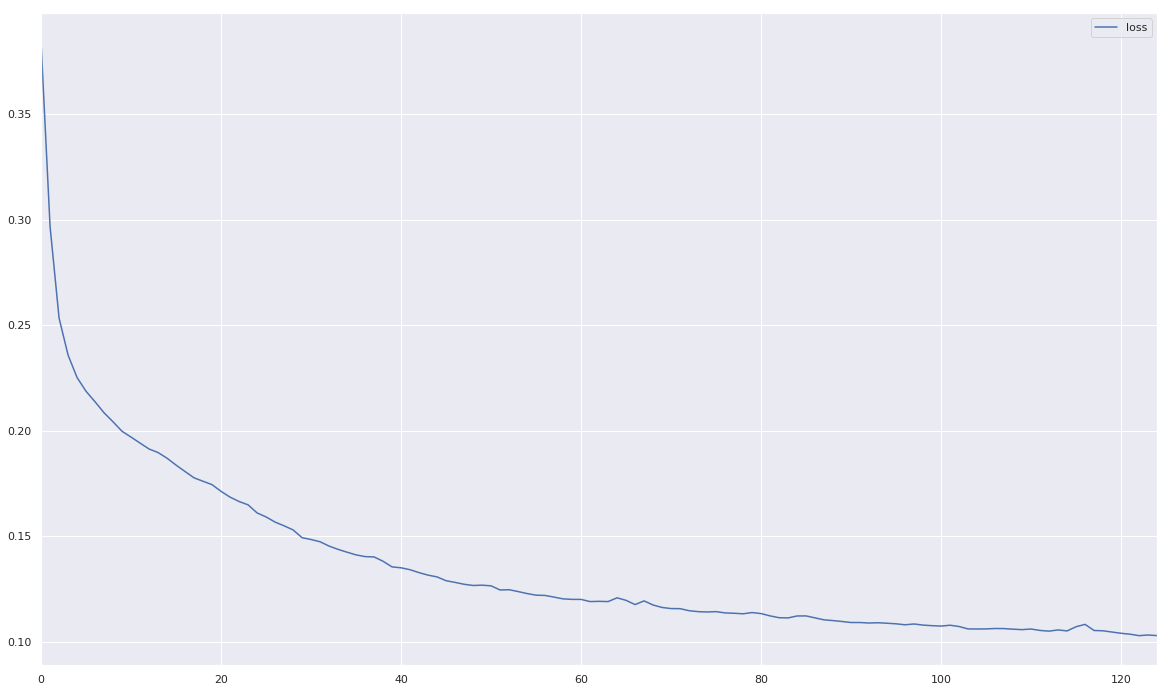

In [12]:
history2 = LSTM_AE.fit(X, X[:,:,y_idx], epochs=125, verbose=0)
history2 = pd.DataFrame(history2.history)
history2.plot()

### Convolutional Autoencoder

In [30]:
inputs = Input(shape=X.shape[1:])
encoder = Conv1D(LOOKBACK, 50, padding='same')(inputs)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = Conv1D(16, 25, padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = Conv1D(8, 15, padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
decoder = Conv1D(16, 25, padding='same')(encoder)
decoder = BatchNormalization()(decoder)
decoder = Activation('relu')(decoder)
decoder = Conv1D(LOOKBACK, 50, padding='same')(decoder)
out = GlobalMaxPooling1D()(decoder)
#out = Dense(LOOKBACK)(decoder)
FCN_AE = Model(inputs, out)
FCN_AE.compile(loss=huber_loss_mean, optimizer='adam')
FCN_AE.summary()
tf.keras.utils.plot_model(FCN_AE, 'fcn_ae.png', show_shapes=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100, 13)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 100, 100)          65100     
_________________________________________________________________
batch_normalization_11 (Batc (None, 100, 100)          400       
_________________________________________________________________
activation_11 (Activation)   (None, 100, 100)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 100, 16)           40016     
_________________________________________________________________
batch_normalization_12 (Batc (None, 100, 16)           64        
_________________________________________________________________
activation_12 (Activation)   (None, 100, 16)           0         
__________

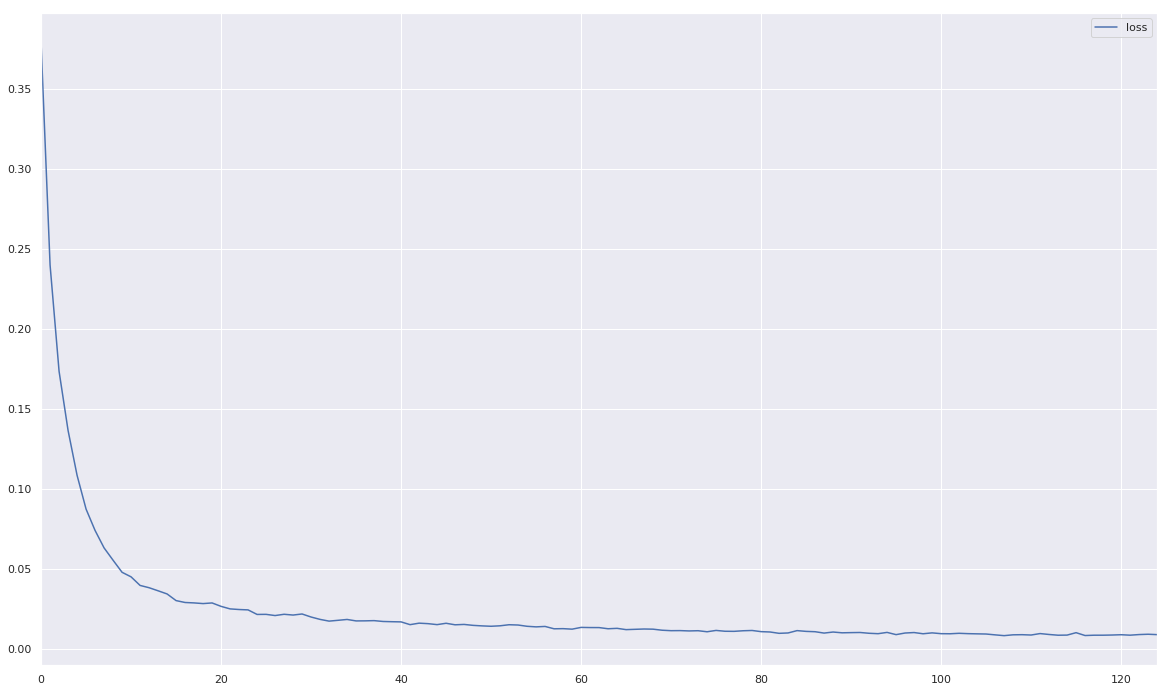

In [31]:
history3 = FCN_AE.fit(X, X[:,:,y_idx], epochs=125, verbose=0)
history3 = pd.DataFrame(history3.history)
history3.plot()

In [32]:
inputs = Input(shape=X.shape[1:])

encoder = Conv1D(LOOKBACK, 48, padding='same')(inputs)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = MaxPooling1D()(encoder)

encoder = Conv1D(16, 24, padding='same')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Activation('relu')(encoder)
encoder = MaxPooling1D()(encoder)

encoder = Conv1D(8, 12, padding='same')(encoder)
#encoder = BatchNormalization()(encoder)
#encoder = Activation('relu')(encoder)

decoder = UpSampling1D()(encoder)
decoder = Conv1D(16, 24, padding='same')(decoder)
decoder = BatchNormalization()(decoder)
decoder = Activation('relu')(decoder)

decoder = UpSampling1D()(decoder)
decoder = Conv1D(LOOKBACK, 48, padding='same')(decoder)
out = GlobalMaxPooling1D()(decoder)
#out = Dense(LOOKBACK)(decoder)
CN_AE = Model(inputs, out)
CN_AE.compile(loss=huber_loss_mean, optimizer='adam')
CN_AE.summary()
tf.keras.utils.plot_model(CN_AE, 'cn_ae.png', show_shapes=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100, 13)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 100, 100)          62500     
_________________________________________________________________
batch_normalization_15 (Batc (None, 100, 100)          400       
_________________________________________________________________
activation_15 (Activation)   (None, 100, 100)          0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 100)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 50, 16)            38416     
_________________________________________________________________
batch_normalization_16 (Batc (None, 50, 16)            64        
__________

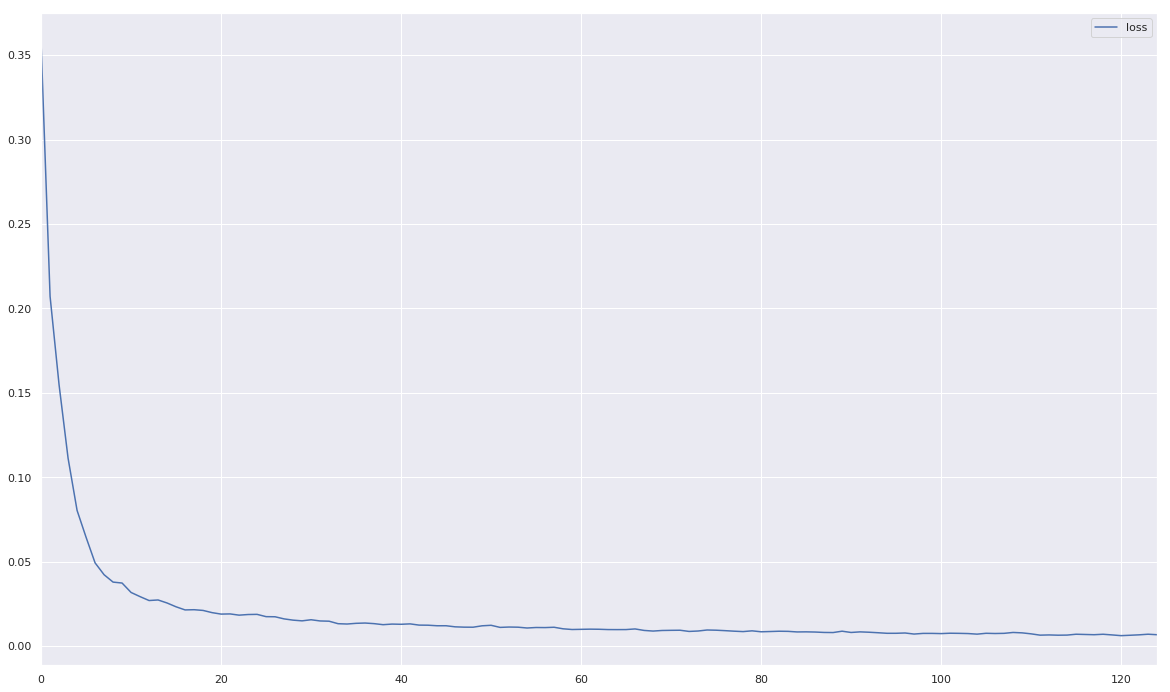

In [33]:
history4 = CN_AE.fit(X, X[:,:,y_idx], epochs=125, verbose=0)
history4 = pd.DataFrame(history4.history)
history4.plot()

## Experiments

As a reconstruction error we use the mean squaered error of our predictions. Below we plot the reconstruction error for each type of simulated error and the detected anomalies. 

In the example tests the convolutional autoencoder showed superior training time. 

In [24]:
ERROR_TYPE = [1, 2, 3] #we can hav different labels for each error or the same label?
max_range = 800
min_range = 0
DATASET_IDX = 0

def model_test(model, min_range, dataset_idx):
    i=1
    for error_type in ERROR_TYPE:
        df_faulty = pd.DataFrame()
        s = 0.
        pathlist = Path(f"/home/aggelos-i3/Downloads/simu Elbas/7h33D{error_type}").glob(
            '**/*.xls')

        for path in pathlist:
            path_in_str = str(path)
            df = pd.read_csv(path_in_str, delimiter='\t', usecols=features)
            if df_faulty.empty:
                df_faulty = df[:1000]
            else:
                df_faulty += df[:1000]
            s += 1.

        df_faulty /= s
        df_faulty = df_faulty.rolling(window=ROLL_WINDOW).mean().dropna()
        y_idx = df_faulty.columns.get_loc('voltage [V]')
        df_scaled_faulty = scaler.fit_transform(df_faulty)
        X_test, y_test = spliter.fit_transform(df_scaled_faulty)
        #X_test = np.delete(X_test, y_idx, 2)
        y_test = y_test[:, :, y_idx]

        yhat = model.predict(X_test)
        #yhat = yhat.reshape(X_test.shape)
        mse = np.mean(np.power(yhat-X_test[:,:,y_idx],2), axis=1)
        
        yhat_normal = model.predict(X)
        #yhat = yhat.reshape(X_test.shape)
        mse_normal = np.mean(np.power(yhat_normal-X[:,:,y_idx],2), axis=1)
        
        df_error = pd.DataFrame({'Abnormal_reconstruction_error': mse,
                                 'Normal_reconstruction_error': mse_normal,
                                 'Label': y_test[:,0]})
        df_error = df_error[:max_range]
        #df_error['reconstruction_error'].plot()
 
        threshold = mse.mean() + 1*mse.std()
        normal_threshold = mse_normal.mean() + 1*mse_normal.std()

        anomaly = mse[min_range:max_range] > threshold
        plt.subplot(3,3,i)
        plt.title(f"Error Type {error_type}")
        plt.plot(df_error['Abnormal_reconstruction_error'][min_range:], label='Abnormal_Reconstruction Error')
        plt.plot(df_error['Normal_reconstruction_error'][min_range:], label='Normal_Reconstruction Error')
        plt.axhline(y=threshold, color='r', linestyle='-', label='Abnormal_threshold')
        plt.axhline(y=normal_threshold, color='g', linestyle='-', label='Normal_Threshold')
        plt.legend(loc='best')


    
        plt.subplot(3,3,i+1)
        plt.scatter(range(min_range,max_range), np.where(anomaly, y_test[min_range:max_range, 0], None), c='r', label='Outliers')
        plt.plot(range(min_range,max_range), y_test[min_range:max_range,0], label='Abnormal Voltage')
        plt.legend(loc='best')
       

 
        anomaly = mse_normal[min_range:max_range] > normal_threshold
        plt.subplot(3,3,i+2)
        plt.scatter(range(min_range,max_range), np.where(anomaly, y_test[min_range:max_range, 0], None), c='r', label='Outliers')
        plt.plot(range(min_range,max_range), y[min_range:max_range,0], label='Normal Voltage')
        plt.legend(loc='best')

        i+=3
    

### AutoEncoder

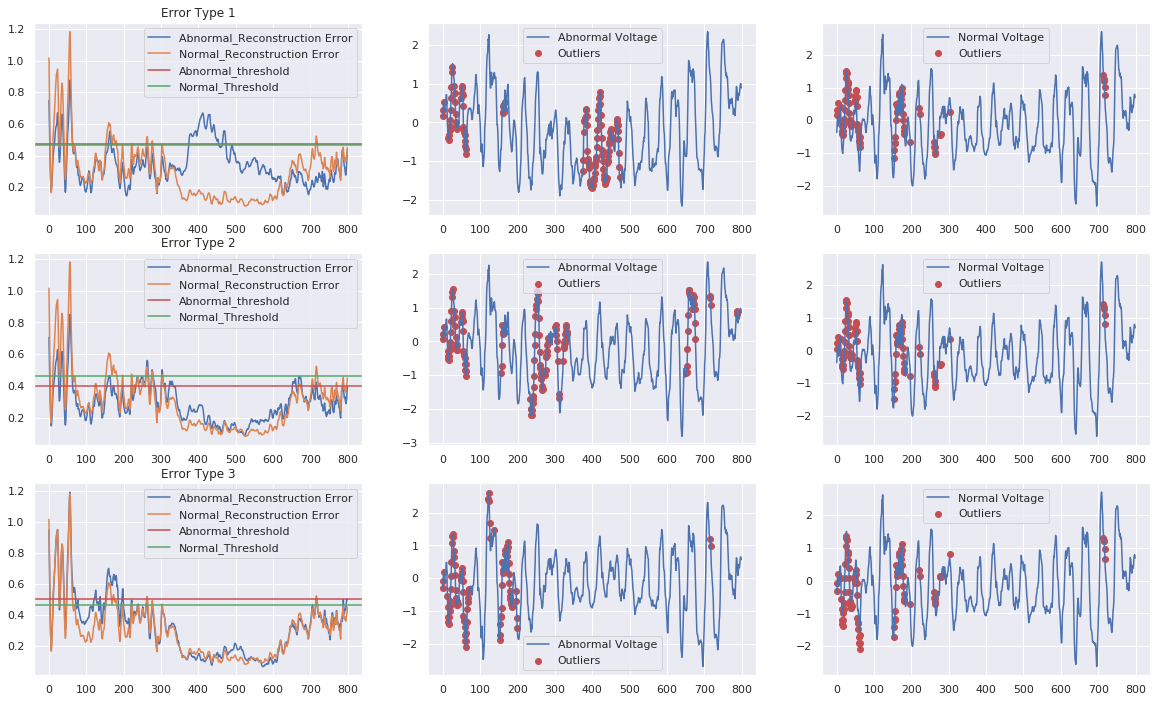

In [25]:
model_test(simple_ae, min_range=0, dataset_idx=0)

### AutoEncoder with Maxpooling Regularization

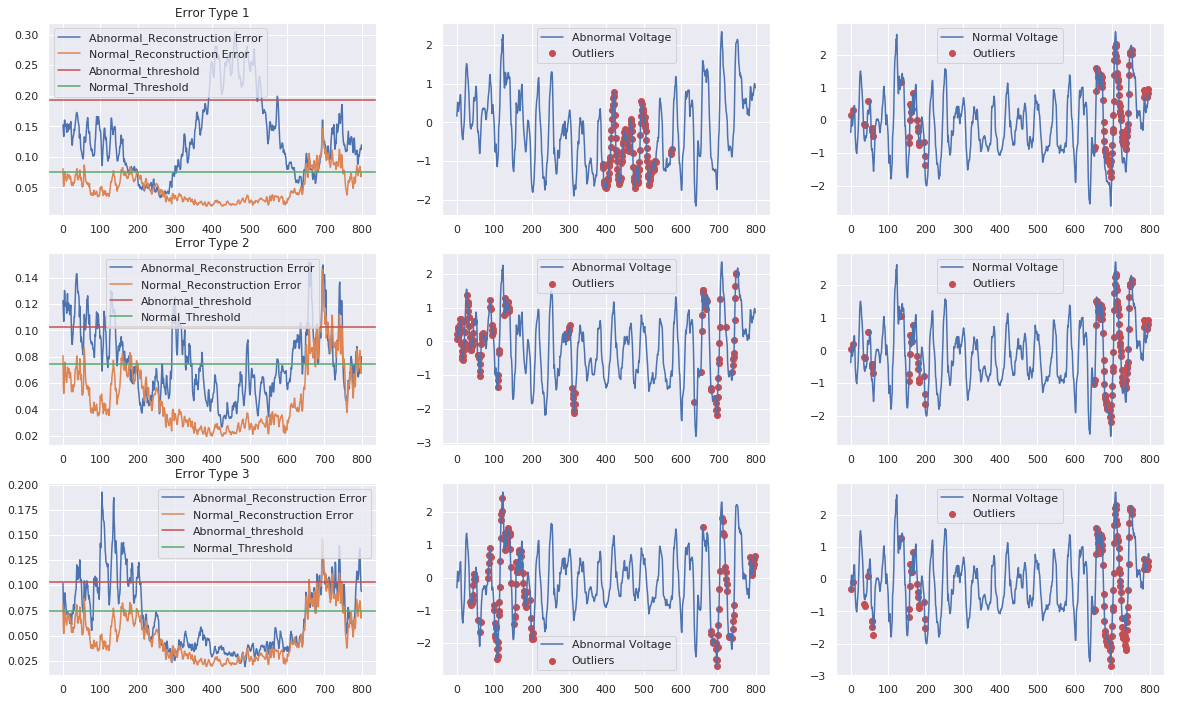

In [26]:
model_test(CN_AE, min_range=0, dataset_idx=0)

### Autoencoder without Max Pooling

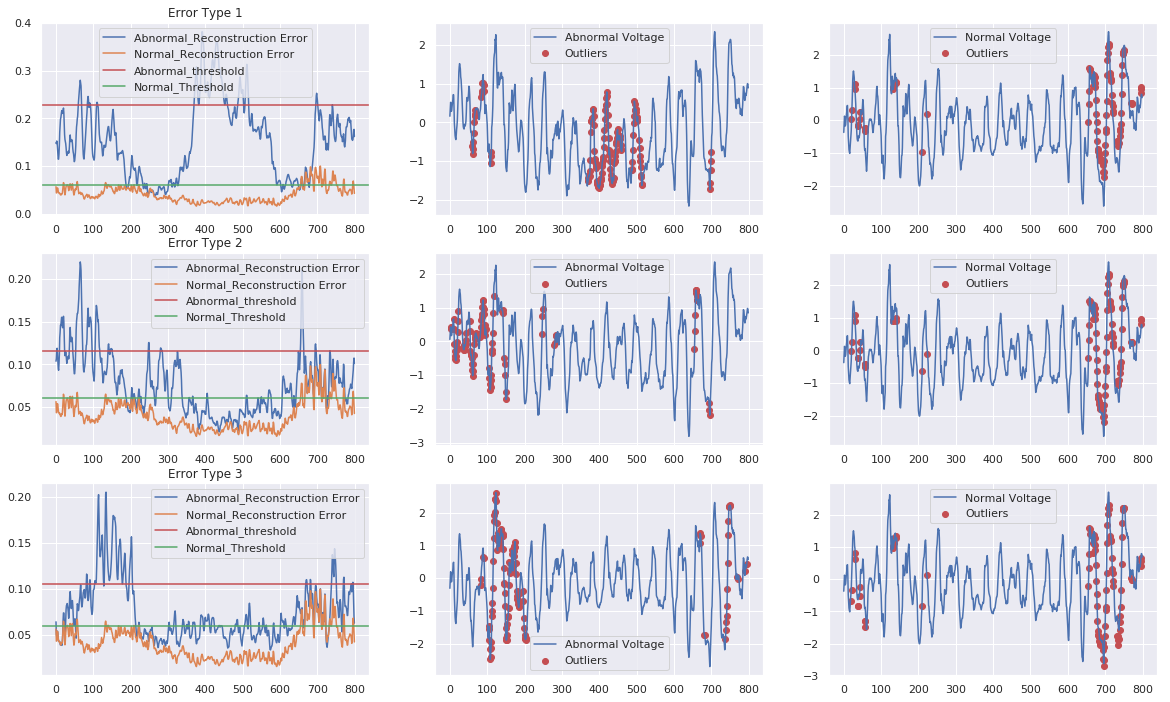

In [27]:
model_test(FCN_AE, min_range=0, dataset_idx=0)

### LSTM Autoencoder

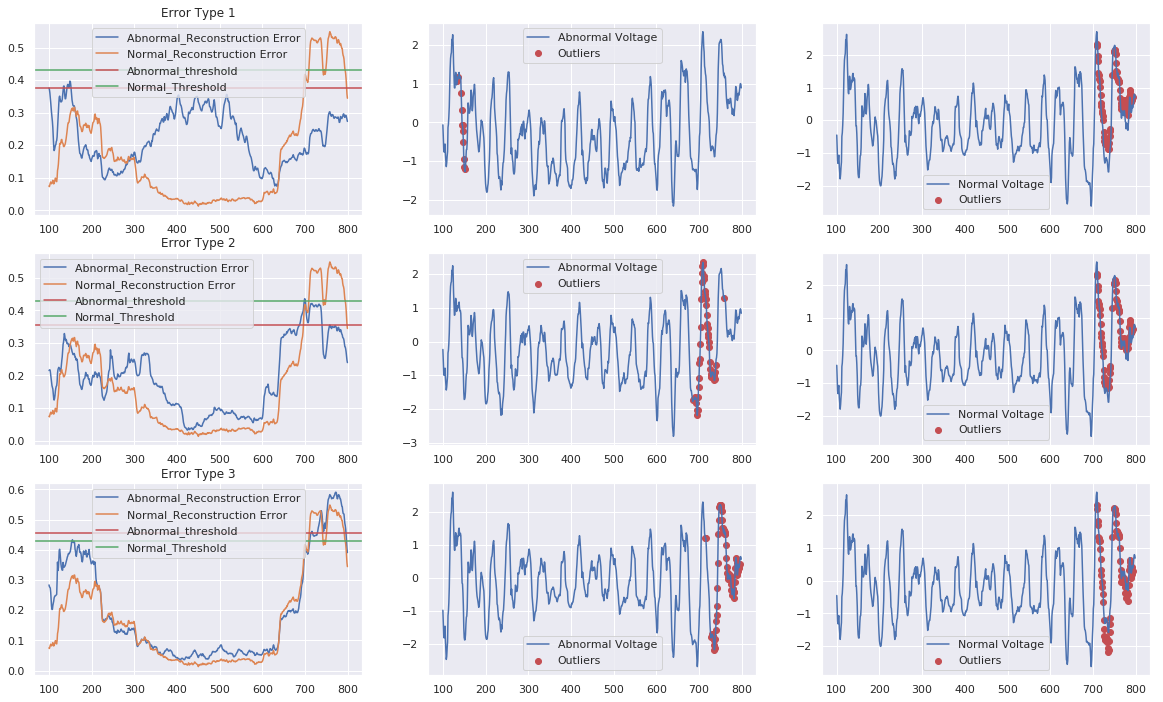

In [28]:
model_test(LSTM_AE, min_range=100, dataset_idx=0)